In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Images batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


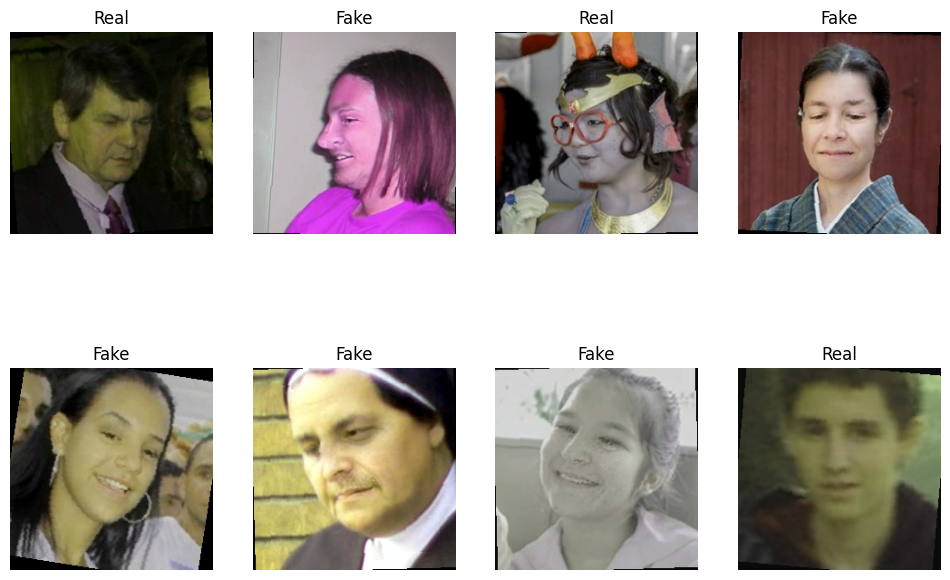

In [ ]:
import zipfile
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

zip_path = '/content/drive/My Drive/dataset.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/Dataset_ml')

train_dir = '/content/Dataset_ml/Dataset/Train'
test_dir = '/content/Dataset_ml/Dataset/Test'
validation_dir = '/content/Dataset_ml/Dataset/Validation'

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
validation_dataset = datasets.ImageFolder(root=validation_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"Images batch shape: {images.shape}")
print(f"Labels batch shape: {labels.shape}")

def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)

class_names = train_dataset.classes

plt.figure(figsize=(12, 8))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    imshow(images[i])
    plt.title(class_names[labels[i]])
    plt.axis('off')

plt.show()

In [ ]:
!pip install timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models import register_model
from typing import Optional

def make_divisible(value: float, divisor: int, min_value: Optional[float] = None, round_down_protect: bool = True) -> int:
    if min_value is None:
        min_value = divisor
    new_value = max(min_value, int(value + divisor / 2) // divisor * divisor)
    if round_down_protect and new_value < 0.9 * value:
        new_value += divisor
    return int(new_value)

def conv2d(in_channels, out_channels, kernel_size=3, stride=1, groups=1, bias=False, norm=True, act=True):
    conv = nn.Sequential()
    padding = (kernel_size - 1) // 2
    conv.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias, groups=groups))
    if norm:
        conv.append(nn.BatchNorm2d(out_channels))
    if act:
        conv.append(nn.ReLU6())
    return conv

class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio, act=False):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]
        hidden_dim = int(round(in_channels * expand_ratio))
        self.block = nn.Sequential()
        if expand_ratio != 1:
            self.block.add_module("exp_1x1", conv2d(in_channels, hidden_dim, kernel_size=1, stride=1))
        self.block.add_module("conv_3x3", conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, groups=hidden_dim))
        self.block.add_module("res_1x1", conv2d(hidden_dim, out_channels, kernel_size=1, stride=1, act=act))
        self.use_res_connect = self.stride == 1 and in_channels == out_channels

    def forward(self, x):
        if self.use_res_connect:
            return x + self.block(x)
        else:
            return self.block(x)

class UniversalInvertedBottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, start_dw_kernel_size, middle_dw_kernel_size, middle_dw_downsample, stride, expand_ratio):
        super(UniversalInvertedBottleneckBlock, self).__init__()
        self.start_dw_kernel_size = start_dw_kernel_size
        if self.start_dw_kernel_size:
            stride_ = stride if not middle_dw_downsample else 1
            self._start_dw_ = conv2d(in_channels, in_channels, kernel_size=start_dw_kernel_size, stride=stride_, groups=in_channels, act=False)
        expand_filters = make_divisible(in_channels * expand_ratio, 8)
        self._expand_conv = conv2d(in_channels, expand_filters, kernel_size=1)
        self.middle_dw_kernel_size = middle_dw_kernel_size
        if self.middle_dw_kernel_size:
            stride_ = stride if middle_dw_downsample else 1
            self._middle_dw = conv2d(expand_filters, expand_filters, kernel_size=middle_dw_kernel_size, stride=stride_, groups=expand_filters)
        self._proj_conv = conv2d(expand_filters, out_channels, kernel_size=1, stride=1, act=False)

    def forward(self, x):
        if self.start_dw_kernel_size:
            x = self._start_dw_(x)
        x = self._expand_conv(x)
        if self.middle_dw_kernel_size:
            x = self._middle_dw(x)
        x = self._proj_conv(x)
        return x

def build_blocks(layer_spec):
    layers = nn.Sequential()
    block_names = layer_spec["block_name"]
    if block_names == "convbn":
        for i in range(layer_spec["num_blocks"]):
            args = layer_spec["block_specs"][i]
            layers.add_module(f"convbn_{i}", conv2d(*args))
    elif block_names == "uib":
        for i in range(layer_spec["num_blocks"]):
            args = layer_spec["block_specs"][i]
            layers.add_module(f"uib_{i}", UniversalInvertedBottleneckBlock(*args))
    elif block_names == "fused_ib":
        for i in range(layer_spec["num_blocks"]):
            args = layer_spec["block_specs"][i]
            layers.add_module(f"fused_ib_{i}", InvertedResidual(*args))
    else:
        raise NotImplementedError
    return layers

MODEL_SPECS = {
    'MobileNetV4ConvSmall': {
        "conv0": {"block_name": "convbn", "num_blocks": 1, "block_specs": [[3, 32, 3, 2]]},
        "layer1": {"block_name": "uib", "num_blocks": 2, "block_specs": [[32, 16, 3, 3, False, 1, 1], [16, 16, 3, 3, True, 1, 1]]},
        "layer2": {"block_name": "uib", "num_blocks": 3, "block_specs": [[16, 24, 3, 3, True, 2, 6], [24, 24, 3, 3, True, 1, 6], [24, 24, 3, 3, True, 1, 6]]},
        "layer3": {"block_name": "uib", "num_blocks": 5, "block_specs": [[24, 40, 3, 3, True, 2, 6], [40, 40, 3, 3, True, 1, 6], [40, 40, 3, 3, True, 1, 6], [40, 40, 3, 3, True, 1, 6], [40, 40, 3, 3, True, 1, 6]]},
        "layer4": {"block_name": "uib", "num_blocks": 3, "block_specs": [[40, 80, 3, 3, True, 2, 6], [80, 80, 3, 3, True, 1, 6], [80, 80, 3, 3, True, 1, 6]]},
        "layer5": {"block_name": "convbn", "num_blocks": 1, "block_specs": [[80, 1280, 1, 1]]},
    },
}

class MobileNetV4(nn.Module):
    def __init__(self, model, num_classes=1000, **kwargs):
        super(MobileNetV4, self).__init__()
        assert model in MODEL_SPECS.keys()
        self.model = model
        self.num_classes = num_classes
        self.spec = MODEL_SPECS[self.model]

        self.conv0 = build_blocks(self.spec["conv0"])
        self.layer1 = build_blocks(self.spec["layer1"])
        self.layer2 = build_blocks(self.spec["layer2"])
        self.layer3 = build_blocks(self.spec["layer3"])
        self.layer4 = build_blocks(self.spec["layer4"])
        self.layer5 = build_blocks(self.spec["layer5"])

        self.head = nn.Linear(1280, num_classes)

    def forward(self, x):
        x0 = self.conv0(x)
        x1 = self.layer1(x0)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)
        x5 = F.adaptive_avg_pool2d(x5, 1)
        out = self.head(x5.flatten(1))
        return out

@register_model
def mobilenetv4_small(pretrained=False, **kwargs):
    model = MobileNetV4('MobileNetV4ConvSmall', **kwargs)
    return model


if __name__ == "__main__":
    model = mobilenetv4_small(num_classes=10)
    print(model)


    test_input = torch.randn(1, 3, 224, 224)
    output = model(test_input)
    print(output.shape)


MobileNetV4(
  (conv0): Sequential(
    (convbn_0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6()
    )
  )
  (layer1): Sequential(
    (uib_0): UniversalInvertedBottleneckBlock(
      (_start_dw_): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (_expand_conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6()
      )
      (_middle_dw): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, aff

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt


# Define the training function
def train_model(model, train_loader, criterion, optimizer, num_epochs, validation_loader=None):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()


            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average loss and accuracy
        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

        # Validate the model
        if validation_loader is not None:
            validate_model(model, validation_loader)

def validate_model(model, validation_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy:.2f}%')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = mobilenetv4_small(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 5
train_model(model, train_loader, criterion, optimizer, num_epochs, validation_loader)

# Save the model after training
torch.save(model.state_dict(), 'mobilenetv4_model.pth')
print("Model saved successfully!")


Epoch [1/5], Loss: 0.3151, Accuracy: 85.15%
Validation Accuracy: 89.66%
Epoch [2/5], Loss: 0.1601, Accuracy: 93.67%
Validation Accuracy: 90.90%
Epoch [3/5], Loss: 0.1294, Accuracy: 94.98%
Validation Accuracy: 94.00%
Epoch [4/5], Loss: 0.1182, Accuracy: 95.33%
Validation Accuracy: 93.65%
Epoch [5/5], Loss: 0.1118, Accuracy: 95.65%
Validation Accuracy: 94.31%
Model saved successfully!


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    return avg_test_loss, test_accuracy

# Load the trained model
model = mobilenetv4_small(num_classes=2).to(device)
model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))
print("Model loaded successfully!")

criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy = test_model(model, test_loader, criterion)


<ipython-input-13-9f2e7f1da662>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))


Model loaded successfully!
Test Loss: 0.2648, Test Accuracy: 89.78%


<ipython-input-15-0cefad2fc680>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))


Model loaded successfully!


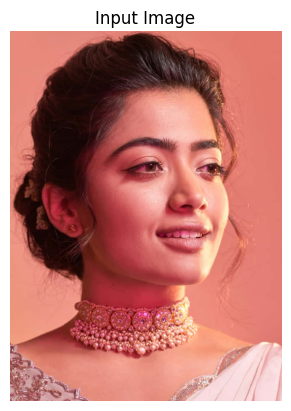

Predicted class: real


In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')

    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')
    plt.show()

    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output.data, 1)

    class_names = ['fake', 'real']
    prediction = class_names[predicted.item()]
    print(f'Predicted class: {prediction}')
    return prediction

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = mobilenetv4_small(num_classes=2).to(device)
model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))
print("Model loaded successfully!")

image_path = 'rashmika_r.jpeg'

prediction = predict_image(image_path, model, transform, device)


<ipython-input-17-1a2fa7e68271>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))


Model loaded successfully!


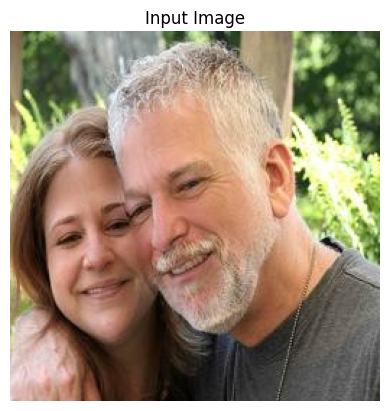

Predicted class: fake


In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')

    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')
    plt.show()

    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output.data, 1)

    class_names = ['fake', 'real']
    prediction = class_names[predicted.item()]
    print(f'Predicted class: {prediction}')
    return prediction

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = mobilenetv4_small(num_classes=2).to(device)
model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))
print("Model loaded successfully!")

image_path = 'fake_5.jpg'

prediction = predict_image(image_path, model, transform, device)


<ipython-input-18-80d17d0f306a>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))


Model loaded successfully!


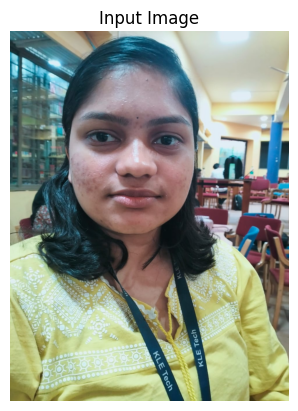

Predicted class: real


In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')

    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')
    plt.show()

    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output.data, 1)

    class_names = ['fake', 'real']
    prediction = class_names[predicted.item()]
    print(f'Predicted class: {prediction}')
    return prediction

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = mobilenetv4_small(num_classes=2).to(device)
model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))
print("Model loaded successfully!")

image_path = 's_r.jpeg'

prediction = predict_image(image_path, model, transform, device)


<ipython-input-19-75d2db3197b7>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))


Model loaded successfully!


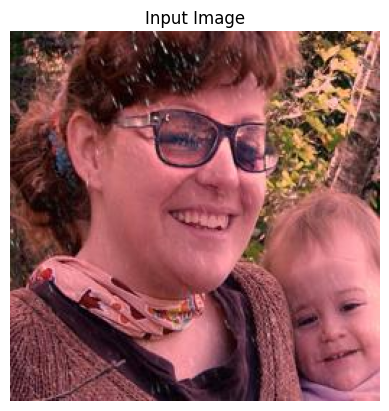

Predicted class: fake


In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')

    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')
    plt.show()

    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output.data, 1)

    class_names = ['fake', 'real']
    prediction = class_names[predicted.item()]
    print(f'Predicted class: {prediction}')
    return prediction

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = mobilenetv4_small(num_classes=2).to(device)
model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))
print("Model loaded successfully!")

image_path = 'fake_2.jpg'

prediction = predict_image(image_path, model, transform, device)


<ipython-input-20-7802e3b556bf>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))


Model loaded successfully!


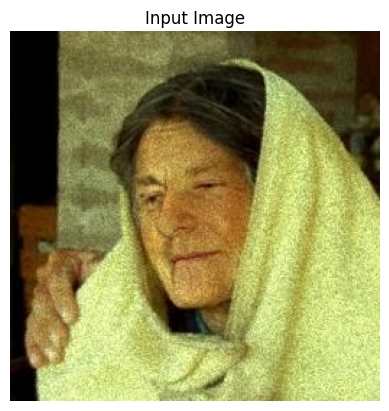

Predicted class: fake


In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')

    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')
    plt.show()

    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output.data, 1)

    class_names = ['fake', 'real']
    prediction = class_names[predicted.item()]
    print(f'Predicted class: {prediction}')
    return prediction

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = mobilenetv4_small(num_classes=2).to(device)
model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))
print("Model loaded successfully!")

image_path = 'fake_0.jpg'

prediction = predict_image(image_path, model, transform, device)

<ipython-input-21-58d2c0c8c0c2>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))


Model loaded successfully!


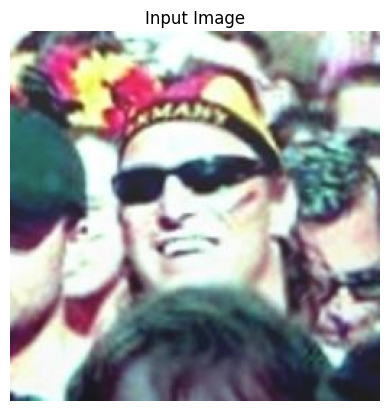

Predicted class: real


In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')

    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')
    plt.show()

    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output.data, 1)

    class_names = ['fake', 'real']
    prediction = class_names[predicted.item()]
    print(f'Predicted class: {prediction}')
    return prediction

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = mobilenetv4_small(num_classes=2).to(device)
model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))
print("Model loaded successfully!")

image_path = 'real_5409.jpg'

prediction = predict_image(image_path, model, transform, device)


<ipython-input-22-b3a32ece6374>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))


Model loaded successfully!


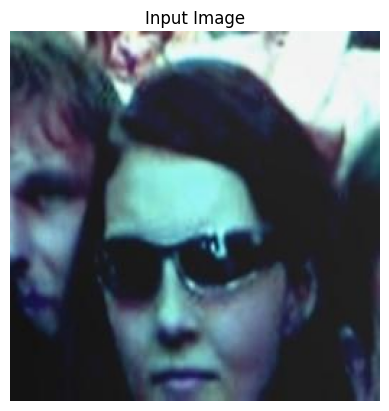

Predicted class: real


In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')

    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')
    plt.show()

    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output.data, 1)

    class_names = ['fake', 'real']
    prediction = class_names[predicted.item()]
    print(f'Predicted class: {prediction}')
    return prediction

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = mobilenetv4_small(num_classes=2).to(device)
model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))
print("Model loaded successfully!")

image_path = 'real_5410.jpg'

prediction = predict_image(image_path, model, transform, device)


<ipython-input-23-81464fa06848>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))


Model loaded successfully!


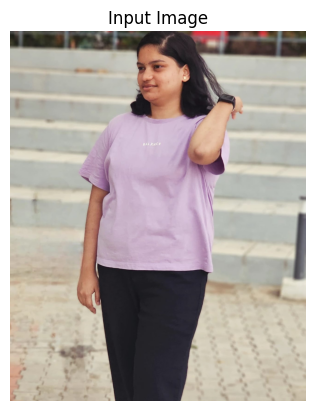

Predicted class: real


In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')

    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')
    plt.show()

    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output.data, 1)

    class_names = ['fake', 'real']
    prediction = class_names[predicted.item()]
    print(f'Predicted class: {prediction}')
    return prediction

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = mobilenetv4_small(num_classes=2).to(device)
model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))
print("Model loaded successfully!")

image_path = 'r2_s.jpeg'

prediction = predict_image(image_path, model, transform, device)


<ipython-input-25-ca6cbe8d23e7>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))


Model loaded successfully!


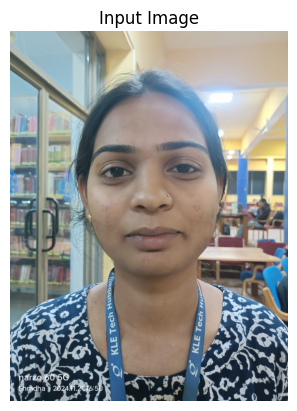

Predicted class: real


In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')

    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')
    plt.show()

    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output.data, 1)

    class_names = ['fake', 'real']
    prediction = class_names[predicted.item()]
    print(f'Predicted class: {prediction}')
    return prediction

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = mobilenetv4_small(num_classes=2).to(device)
model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))
print("Model loaded successfully!")

image_path = 'vai_r_2.jpeg'

prediction = predict_image(image_path, model, transform, device)


<ipython-input-26-2764209e055d>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))


Model loaded successfully!


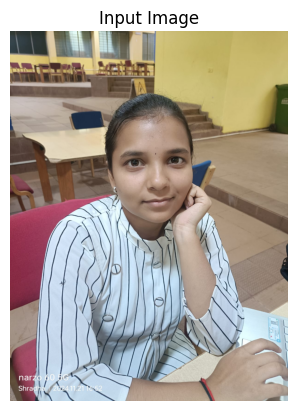

Predicted class: real


In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')

    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')
    plt.show()

    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output.data, 1)

    class_names = ['fake', 'real']
    prediction = class_names[predicted.item()]
    print(f'Predicted class: {prediction}')
    return prediction

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = mobilenetv4_small(num_classes=2).to(device)
model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))
print("Model loaded successfully!")

image_path = 'sou_r.jpeg'

prediction = predict_image(image_path, model, transform, device)


<ipython-input-27-0dc08dfba16a>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))


Model loaded successfully!


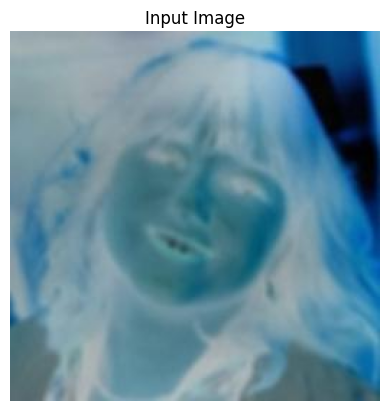

Predicted class: real


In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')

    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')
    plt.show()

    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output.data, 1)

    class_names = ['fake', 'real']
    prediction = class_names[predicted.item()]
    print(f'Predicted class: {prediction}')
    return prediction

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = mobilenetv4_small(num_classes=2).to(device)
model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))
print("Model loaded successfully!")

image_path = 'r_rr.jpeg'

prediction = predict_image(image_path, model, transform, device)


<ipython-input-30-c07ad5dd63a6>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))


Model loaded successfully!


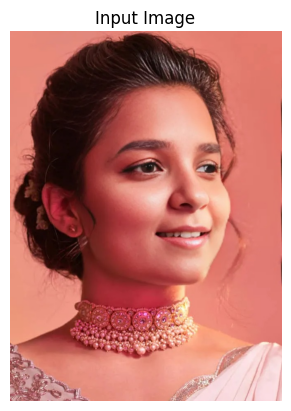

Predicted class: fake


In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')

    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')
    plt.show()

    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output.data, 1)

    class_names = ['fake', 'real']
    prediction = class_names[predicted.item()]
    print(f'Predicted class: {prediction}')
    return prediction

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = mobilenetv4_small(num_classes=2).to(device)
model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))
print("Model loaded successfully!")

image_path = 'rash_sou.jpg'

prediction = predict_image(image_path, model, transform, device)


<ipython-input-32-41d0b33240e4>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))


Model loaded successfully!


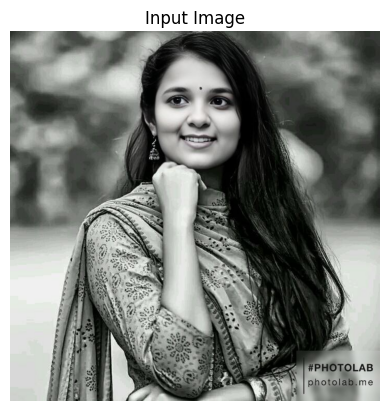

Predicted class: fake


In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')

    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')
    plt.show()

    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output.data, 1)

    class_names = ['fake', 'real']
    prediction = class_names[predicted.item()]
    print(f'Predicted class: {prediction}')
    return prediction

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = mobilenetv4_small(num_classes=2).to(device)
model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))
print("Model loaded successfully!")

image_path = 'sj_f.jpeg'

prediction = predict_image(image_path, model, transform, device)


<ipython-input-14-2b918e4b5f18>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))


Model loaded successfully!


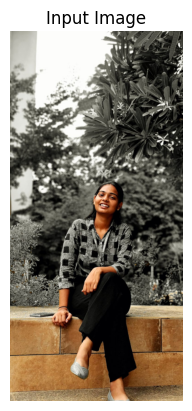

Predicted class: real


In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')

    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')
    plt.show()

    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output.data, 1)

    class_names = ['fake', 'real']
    prediction = class_names[predicted.item()]
    print(f'Predicted class: {prediction}')
    return prediction

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = mobilenetv4_small(num_classes=2).to(device)
model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))
print("Model loaded successfully!")

image_path = 'vaish_r_2.jpeg'

prediction = predict_image(image_path, model, transform, device)


<ipython-input-15-a8d6e8f23de1>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))


Model loaded successfully!


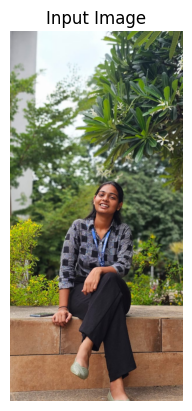

Predicted class: real


In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')

    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')
    plt.show()

    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output.data, 1)

    class_names = ['fake', 'real']
    prediction = class_names[predicted.item()]
    print(f'Predicted class: {prediction}')
    return prediction

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = mobilenetv4_small(num_classes=2).to(device)
model.load_state_dict(torch.load('mobilenetv4_model_epoch_11.pth'))
print("Model loaded successfully!")

image_path = 'vaish_rr_2.jpeg'

prediction = predict_image(image_path, model, transform, device)
